# ECE (Expected Calibration Error) Analysis

This notebook analyzes the calibration of model predictions using Expected Calibration Error (ECE) and visualizes the results with histograms.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
import helpers as ph
import dataframe_image as dfi
import ast
import re

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

RESULTS_DIR = './data/distributions/'
CONTEXT = 'default'
SAVEFIG = True

In [2]:
# Load combined data
combined_df = []
for wave in ph.PEW_SURVEY_LIST:
    SURVEY_NAME = f'American_Trends_Panel_W{wave}'
    cdf = pd.read_csv(os.path.join(RESULTS_DIR, f'{SURVEY_NAME}_{CONTEXT}_combined.csv'))
    cdf['survey'] = f'ATP {wave}'
    combined_df.append(cdf)
combined_df = pd.concat(combined_df)
combined_df['Source'] = combined_df.apply(lambda x: 'AI21 Labs' if 'j1-' in x['model_name'].lower() else 'OpenAI',
                                          axis=1)

print(f"Loaded data for {len(combined_df)} rows")
print(f"Columns: {combined_df.columns.tolist()}")

Loaded data for 825120 rows
Columns: ['Unnamed: 0', 'input_id', 'question_raw', 'question', 'references', 'context', 'mapping', 'top_k_logprobs', 'logprobs', 'probs_unnorm', 'probs_norm', 'misses', 'D_M', 'R_M', 'ordinal', 'ordinal_refs', 'refusal_refs', 'qkey', 'results_path', 'context_type', 'model_name', 'model_order', 'attribute', 'group', 'D_H', 'R_H', 'group_order', 'WD', 'survey', 'Source']


In [3]:
# Check data format for D_M and D_H columns
print("Checking data formats...")
sample_row = combined_df.iloc[0]
print(f"D_M type: {type(sample_row['D_M'])}")
print(f"D_H type: {type(sample_row['D_H'])}")
print(f"D_M sample: {repr(sample_row['D_M'])}")
print(f"D_H sample: {repr(sample_row['D_H'])}")

# Check multiple samples to understand the pattern
print("\nChecking multiple samples:")
for i in range(min(5, len(combined_df))):
    row = combined_df.iloc[i]
    print(f"Row {i}: D_M={repr(row['D_M'])[:100]}...")
    print(f"Row {i}: D_H={repr(row['D_H'])[:100]}...")

Checking data formats...
D_M type: <class 'str'>
D_H type: <class 'str'>
D_M sample: '[0.27070319 0.24841121 0.29042213 0.19046348]'
D_H sample: '[0.22466215 0.57038214 0.15717321 0.04778249]'

Checking multiple samples:
Row 0: D_M='[0.27070319 0.24841121 0.29042213 0.19046348]'...
Row 0: D_H='[0.22466215 0.57038214 0.15717321 0.04778249]'...
Row 1: D_M='[0.27070319 0.24841121 0.29042213 0.19046348]'...
Row 1: D_H='[0.2441665  0.58523134 0.1388322  0.03176995]'...
Row 2: D_M='[0.27070319 0.24841121 0.29042213 0.19046348]'...
Row 2: D_H='[0.32961366 0.53010117 0.11288551 0.02739966]'...
Row 3: D_M='[0.27070319 0.24841121 0.29042213 0.19046348]'...
Row 3: D_H='[0.17962596 0.57108804 0.17289623 0.07638977]'...
Row 4: D_M='[0.27070319 0.24841121 0.29042213 0.19046348]'...
Row 4: D_H='[0.19395099 0.58853195 0.18465851 0.03285855]'...


In [4]:
def safe_parse_distribution(dist):
    """Safely parse distribution data from various formats"""
    if isinstance(dist, list):
        return dist
    elif isinstance(dist, str):
        # Clean the string
        dist = dist.strip()
        
        # Handle empty strings
        if not dist:
            return []
            
        # Try different parsing methods
        try:
            # Method 1: Direct eval for list strings
            if dist.startswith('[') and dist.endswith(']'):
                try:
                    return ast.literal_eval(dist)
                except:
                    # If eval fails, try parsing the content inside brackets
                    content = dist[1:-1].strip()
                    # Try comma-separated
                    if ',' in content:
                        return [float(x.strip()) for x in content.split(',') if x.strip()]
                    else:
                        # Space-separated
                        return [float(x) for x in content.split() if x]
            
            # Method 2: Space-separated values (no brackets)
            elif ' ' in dist:
                return [float(x) for x in dist.split() if x]
            
            # Method 3: Comma-separated values (no brackets)
            elif ',' in dist:
                return [float(x.strip()) for x in dist.split(',') if x.strip()]
            
            # Method 4: Single value
            else:
                return [float(dist)]
                
        except Exception as e:
            print(f"Warning: Could not parse distribution: {repr(dist)}")
            print(f"Error: {e}")
            return []
    elif isinstance(dist, np.ndarray):
        return dist.tolist()
    else:
        print(f"Warning: Unknown distribution type: {type(dist)}")
        return []

# Test the parsing function with problematic cases
test_cases = [
    "[0.27070319 0.24841121 0.29042213 0.19046348]",
    "[0.27070319, 0.24841121, 0.29042213, 0.19046348]",
    [0.27070319, 0.24841121, 0.29042213, 0.19046348],
    "0.27070319 0.24841121 0.29042213 0.19046348",
    "0.27070319,0.24841121,0.29042213,0.19046348",
    ""
]

print("Testing parsing function:")
for i, test in enumerate(test_cases):
    result = safe_parse_distribution(test)
    print(f"Test {i+1}: {repr(test)} -> {result}")

Testing parsing function:
Test 1: '[0.27070319 0.24841121 0.29042213 0.19046348]' -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
Test 2: '[0.27070319, 0.24841121, 0.29042213, 0.19046348]' -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
Test 3: [0.27070319, 0.24841121, 0.29042213, 0.19046348] -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
Test 4: '0.27070319 0.24841121 0.29042213 0.19046348' -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
Test 5: '0.27070319,0.24841121,0.29042213,0.19046348' -> [0.27070319, 0.24841121, 0.29042213, 0.19046348]
Test 6: '' -> []


## ECE Calculation Methodology

Expected Calibration Error (ECE) measures how well a model's predicted probabilities match the actual observed frequencies. We'll calculate ECE for each model by:

1. Binning predictions by confidence level
2. Calculating the absolute difference between average confidence and accuracy in each bin
3. Weighting by the number of samples in each bin

In [5]:
def calculate_ece(model_probs, ‘
                  , n_bins=10):
    """
    计算 Expected Calibration Error (ECE)
    
    参数:
    ### - model_probs: 模型预测概率数组，每个选项的概率
    ### - human_probs: 实际人类响应概率数组，每个选项的概率
    - n_bins: 校准分析的分桶数量
    
    返回:
    - ece: 预期校准误差
    - bin_stats: 每个桶的统计信息
    """
    # Flatten the probability arrays
    model_flat = np.concatenate(model_probs)
    human_flat = np.concatenate(human_probs)
    
    # Create bins
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(model_flat, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    ece = 0.0
    bin_stats = []
    
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_conf = np.mean(model_flat[mask])  # 平均置信度
            bin_acc = np.mean(human_flat[mask])   # 平均准确率
            bin_weight = np.sum(mask) / len(model_flat)
            bin_ece = bin_weight * np.abs(bin_conf - bin_acc)   # 当前桶的ECE贡献
            ece += bin_ece
            
            bin_stats.append({
                'bin': i,
                'bin_start': bin_edges[i],
                'bin_end': bin_edges[i+1],
                'confidence': bin_conf,
                'accuracy': bin_acc,
                'count': np.sum(mask),
                'weight': bin_weight,
                'ece_contribution': bin_ece
            })
    
    return ece, bin_stats

def calculate_model_ece(combined_data, n_bins=10):
    """
    Calculate ECE for each model across all questions
    为每个模型计算所有问题的ECE

    combined_data: 包含模型和人类分布数据的DataFrame
    n_bins: 分桶数量
    """
    model_ece_results = []

    # 为每个模型计算ECE
    for model_name in combined_data['model_name'].unique():
        model_data = combined_data[combined_data['model_name'] == model_name]
        
        # Extract probability distributions
        # 提取概率分布
        model_probs = []
        human_probs = []
        
        for _, row in model_data.iterrows():
            d_m = safe_parse_distribution(row['D_M'])  # 模型分布
            d_h = safe_parse_distribution(row['D_H'])  # 人类分布

            # 只使用有效数据
            if len(d_m) > 0 and len(d_h) > 0:
                model_probs.append(d_m)
                human_probs.append(d_h)
        
        # Only calculate ECE if we have valid data
        if len(model_probs) > 0:
            # Calculate ECE
            ece, bin_stats = calculate_ece(model_probs, human_probs, n_bins)
            
            model_ece_results.append({
                'model_name': model_name,
                'source': 'AI21 Labs' if 'j1-' in model_name.lower() else 'OpenAI',
                'ece': ece,
                'n_questions': len(model_data),   # 总问题数
                'n_valid_questions': len(model_probs),   # 有效问题数
                'bin_stats': bin_stats   # 桶统计信息
            })
        else:
            print(f"Warning: No valid data for model {model_name}")
    
    return pd.DataFrame(model_ece_results)

In [6]:
# Calculate ECE for all models
print("Calculating ECE for all models...")
ece_results = calculate_model_ece(combined_df)

# Sort by ECE (lower is better)
ece_results = ece_results.sort_values('ece')

print("\nECE Results (lower is better):")
for _, row in ece_results.iterrows():
    print(f"{row['model_name']:30} ECE: {row['ece']:.4f} (based on {row['n_valid_questions']} questions)")

Calculating ECE for all models...

ECE Results (lower is better):
j1-grande                      ECE: 0.0377 (based on 91680 questions)
ada                            ECE: 0.0452 (based on 91680 questions)
j1-jumbo                       ECE: 0.0636 (based on 91680 questions)
j1-grande-v2-beta              ECE: 0.0940 (based on 91680 questions)
davinci                        ECE: 0.1170 (based on 91680 questions)
text-davinci-002               ECE: 0.1949 (based on 91680 questions)
text-ada-001                   ECE: 0.2421 (based on 91680 questions)
text-davinci-001               ECE: 0.2543 (based on 91680 questions)
text-davinci-003               ECE: 0.3010 (based on 91680 questions)


## ECE Visualization with Histograms

/tmp/ipykernel_1080/3490684149.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(source_data, labels=ece_results['source'].unique(),


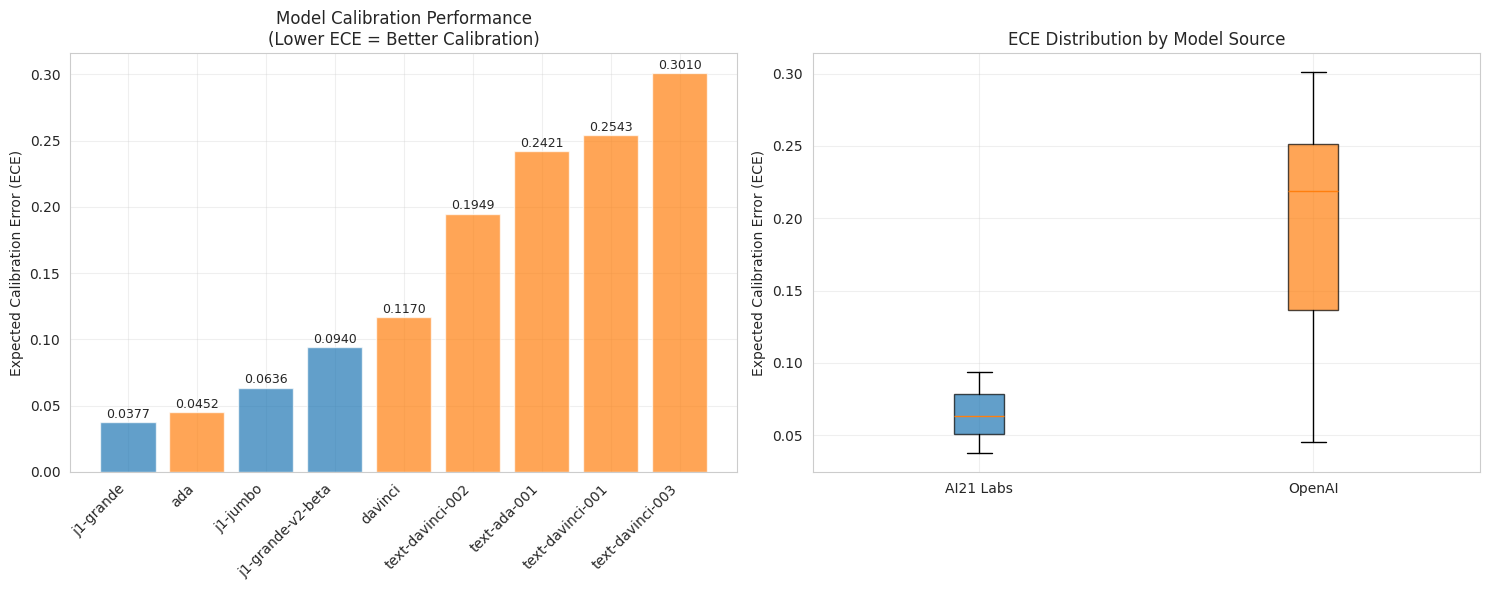

In [7]:
"""
    1. **柱状图**：比较所有模型的ECE值,
    2. **箱线图**：按模型来源比较ECE分布,
    3. **可靠性图**：显示预测置信度与实际准确率的关系,
    4. **校准直方图**：详细展示最佳和最差模型的校准情况"
    
"""


# Bar chart of ECE by model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: ECE by model (bar chart)
# 图1: 按模型显示的ECE柱状图
colors = ['#1f77b4' if 'AI21' in source else '#ff7f0e' for source in ece_results['source']]
bars = ax1.bar(range(len(ece_results)), ece_results['ece'], color=colors, alpha=0.7)
ax1.set_xticks(range(len(ece_results)))
ax1.set_xticklabels(ece_results['model_name'], rotation=45, ha='right')
ax1.set_ylabel('Expected Calibration Error (ECE)')
ax1.set_title('Model Calibration Performance\n(Lower ECE = Better Calibration)')
ax1.grid(True, alpha=0.3)

# Add value labels on bars

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 2: ECE by source (box plot)
# 图2: 按来源显示的ECE箱线图
source_data = []
for source in ece_results['source'].unique():
    source_ece = ece_results[ece_results['source'] == source]['ece'].values
    source_data.append(source_ece)

box_plot = ax2.boxplot(source_data, labels=ece_results['source'].unique(), 
                       patch_artist=True)
colors = ['#1f77b4', '#ff7f0e']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Expected Calibration Error (ECE)')
ax2.set_title('ECE Distribution by Model Source')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if SAVEFIG:
    plt.savefig('./figures/ece_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

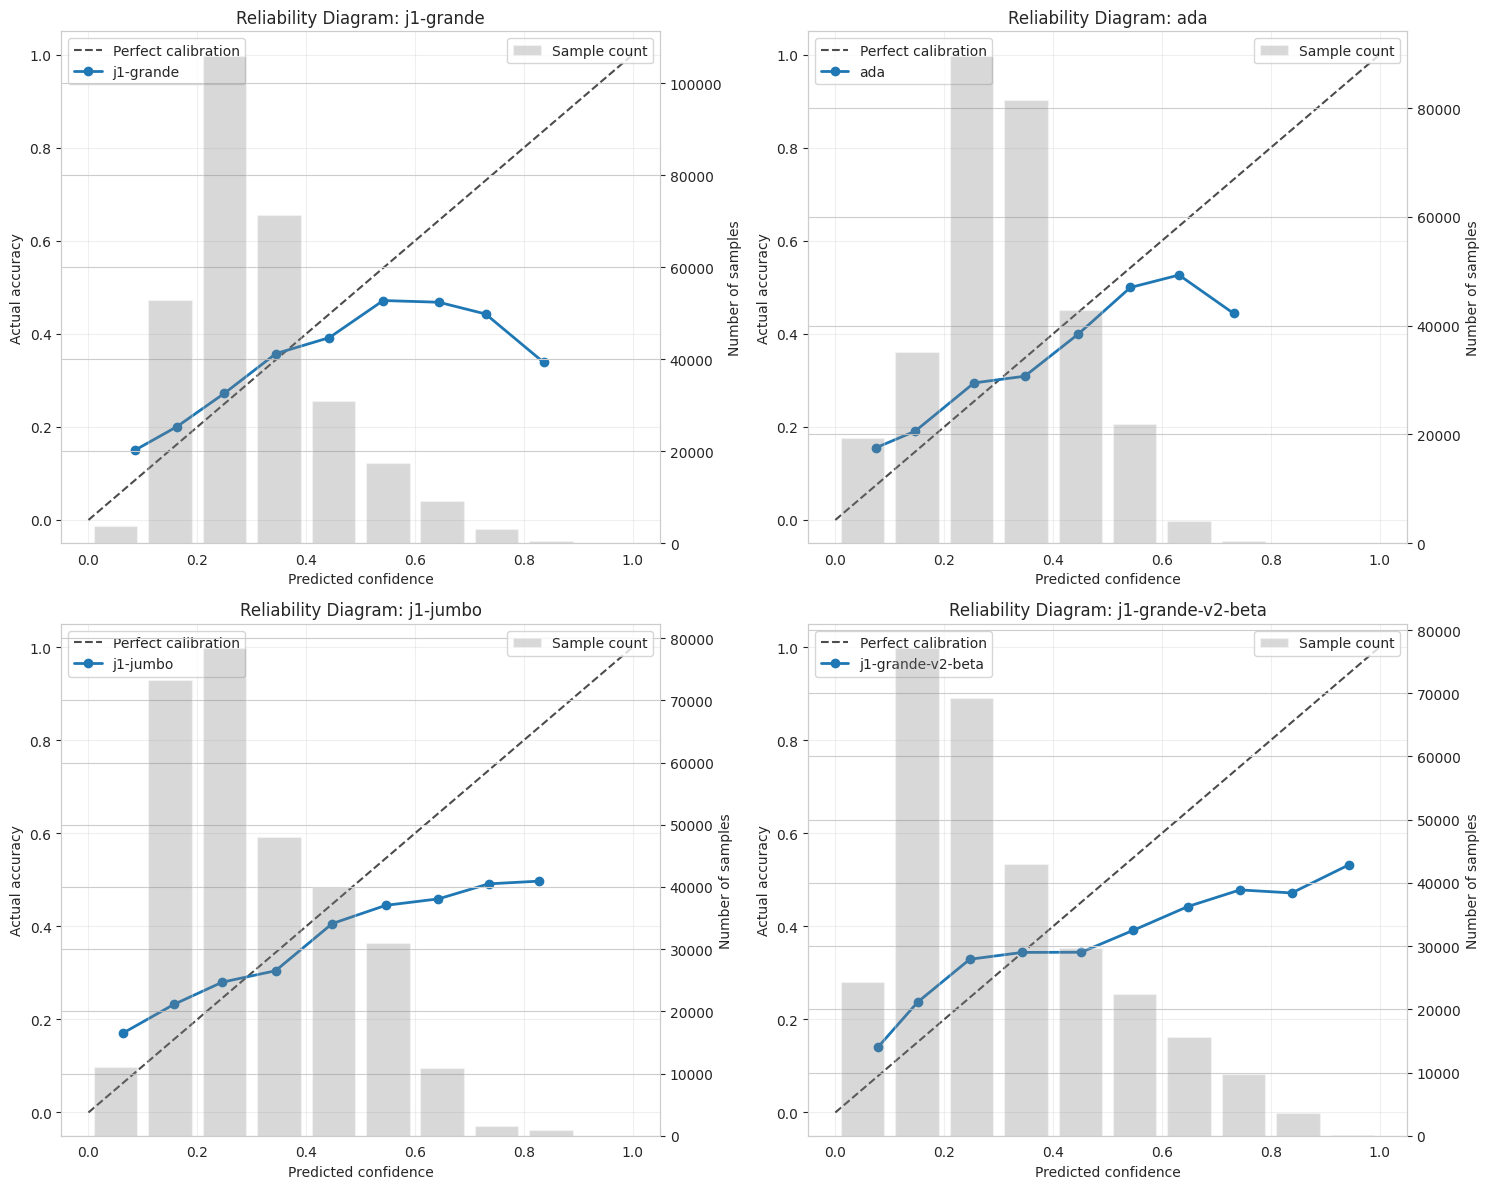

In [8]:
# Reliability diagrams for selected models
def plot_reliability_diagram(model_name, bin_stats, ax):
    """Plot reliability diagram for a single model
    为单个模型绘制可靠性图,
        可靠性图显示预测置信度与实际准确率之间的关系：
        完美校准：所有点都在对角线上,
        过度自信：点在对角线下方,
        信心不足：点在对角线上方
    
    """

    # 提取置信度和准确率
    confidences = [stat['confidence'] for stat in bin_stats]
    accuracies = [stat['accuracy'] for stat in bin_stats]
    counts = [stat['count'] for stat in bin_stats]
    
    # Plot reliability curve
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Perfect calibration')
    ax.plot(confidences, accuracies, 'o-', linewidth=2, markersize=6, 
            label=f'{model_name}')
    
    # Add histogram of counts
    ax2 = ax.twinx()
    bin_centers = [(stat['bin_start'] + stat['bin_end']) / 2 for stat in bin_stats]
    ax2.bar(bin_centers, counts, alpha=0.3, width=0.08, color='gray', 
            label='Sample count')
    ax2.set_ylabel('Number of samples')
    
    ax.set_xlabel('Predicted confidence')
    ax.set_ylabel('Actual accuracy')
    ax.set_title(f'Reliability Diagram: {model_name}')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Plot reliability diagrams for top and bottom performing models
n_models_to_plot = min(4, len(ece_results))
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i in range(n_models_to_plot):
    model_row = ece_results.iloc[i]
    plot_reliability_diagram(model_row['model_name'], model_row['bin_stats'], axes[i])

plt.tight_layout()
if SAVEFIG:
    plt.savefig('./figures/reliability_diagrams.png', bbox_inches='tight', dpi=300)
plt.show()

Best model: j1-grande (ECE: 0.0377)
Worst model: text-davinci-003 (ECE: 0.3010)
Best model bins: 9, Worst model bins: 10


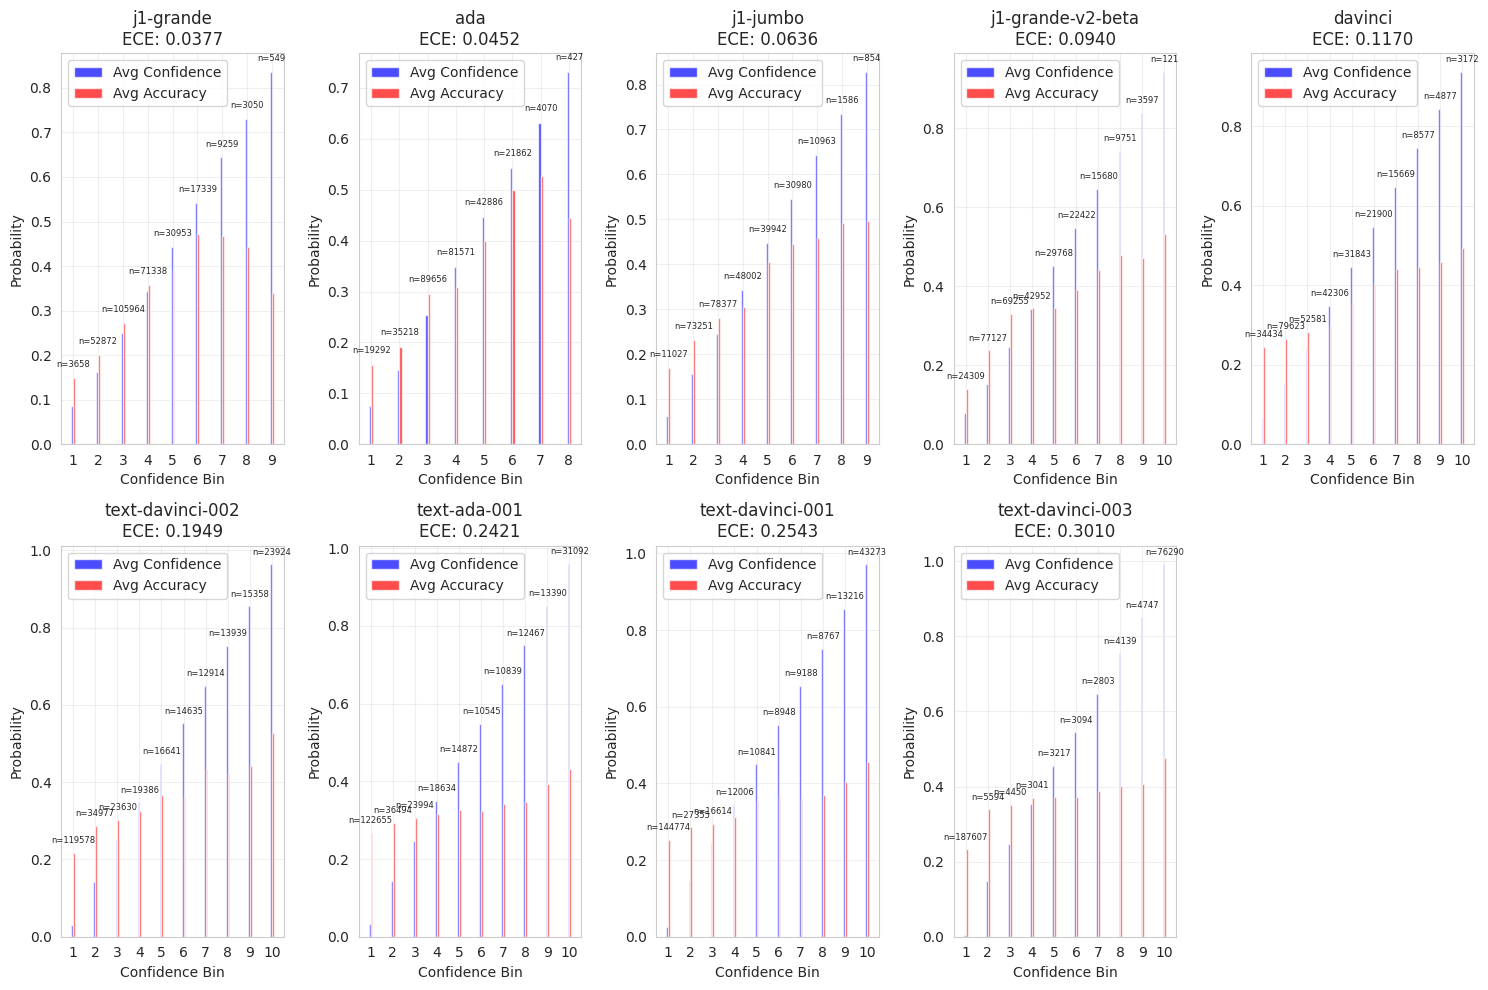

In [9]:
# Fixed version: Detailed calibration histogram for the best and worst models
def plot_calibration_histogram(best_model, worst_model, ece_results):
    """Plot detailed calibration histogram comparing best and worst models
    绘制最佳和最差模型的详细校准直方图比较
        这个图显示每个置信度桶中：
        蓝色柱：平均预测置信度
        红色柱：平均实际准确率
        理想情况：蓝柱和红柱高度相同
    """
    
    best_stats = ece_results[ece_results['model_name'] == best_model]['bin_stats'].iloc[0]
    worst_stats = ece_results[ece_results['model_name'] == worst_model]['bin_stats'].iloc[0]
    
    # Ensure both models have the same number of bins
    n_bins = min(len(best_stats), len(worst_stats))
    best_stats = best_stats[:n_bins]
    worst_stats = worst_stats[:n_bins]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Best model
    conf_best = [stat['confidence'] for stat in best_stats]
    acc_best = [stat['accuracy'] for stat in best_stats]
    counts_best = [stat['count'] for stat in best_stats]
    
    width = 0.08
    x_pos = np.arange(len(conf_best))
    
    bars1 = ax1.bar(x_pos - width/2, conf_best, width, label='Avg Confidence', 
                    alpha=0.7, color='blue')
    bars2 = ax1.bar(x_pos + width/2, acc_best, width, label='Avg Accuracy', 
                    alpha=0.7, color='red')
    
    ax1.set_xlabel('Confidence Bin')
    ax1.set_ylabel('Probability')
    ax1.set_title(f'Best Model: {best_model}\nECE: {ece_results[ece_results["model_name"] == best_model]["ece"].iloc[0]:.4f}')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'{i+1}' for i in range(len(conf_best))])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add count labels
    for i, count in enumerate(counts_best):
        ax1.text(i, max(conf_best[i], acc_best[i]) + 0.02, f'n={count}', 
                ha='center', va='bottom', fontsize=8)
    
    # Worst model
    conf_worst = [stat['confidence'] for stat in worst_stats]
    acc_worst = [stat['accuracy'] for stat in worst_stats]
    counts_worst = [stat['count'] for stat in worst_stats]
    
    bars3 = ax2.bar(x_pos - width/2, conf_worst, width, label='Avg Confidence', 
                    alpha=0.7, color='blue')
    bars4 = ax2.bar(x_pos + width/2, acc_worst, width, label='Avg Accuracy', 
                    alpha=0.7, color='red')
    
    ax2.set_xlabel('Confidence Bin')
    ax2.set_ylabel('Probability')
    ax2.set_title(f'Worst Model: {worst_model}\nECE: {ece_results[ece_results["model_name"] == worst_model]["ece"].iloc[0]:.4f}')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'{i+1}' for i in range(len(conf_worst))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add count labels
    for i, count in enumerate(counts_worst):
        ax2.text(i, max(conf_worst[i], acc_worst[i]) + 0.02, f'n={count}', 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    if SAVEFIG:
        plt.savefig('./figures/calibration_histogram_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()

# Alternative version: Individual histograms
def plot_individual_calibration_histograms(ece_results):
    """Plot individual calibration histograms for each model"""
    
    n_models = len(ece_results)
    fig, axes = plt.subplots(2, (n_models + 1) // 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (_, model_row) in enumerate(ece_results.iterrows()):
        if i >= len(axes):
            break
            
        model_name = model_row['model_name']
        bin_stats = model_row['bin_stats']
        ece = model_row['ece']
        
        confidences = [stat['confidence'] for stat in bin_stats]
        accuracies = [stat['accuracy'] for stat in bin_stats]
        counts = [stat['count'] for stat in bin_stats]
        
        width = 0.08
        x_pos = np.arange(len(confidences))
        
        axes[i].bar(x_pos - width/2, confidences, width, label='Avg Confidence', 
                   alpha=0.7, color='blue')
        axes[i].bar(x_pos + width/2, accuracies, width, label='Avg Accuracy', 
                   alpha=0.7, color='red')
        
        axes[i].set_xlabel('Confidence Bin')
        axes[i].set_ylabel('Probability')
        axes[i].set_title(f'{model_name}\nECE: {ece:.4f}')
        axes[i].set_xticks(x_pos)
        axes[i].set_xticklabels([f'{j+1}' for j in range(len(confidences))])
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Add count labels
        for j, count in enumerate(counts):
            axes[i].text(j, max(confidences[j], accuracies[j]) + 0.02, f'n={count}', 
                    ha='center', va='bottom', fontsize=6)
    
    # Hide unused subplots
    for i in range(n_models, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    if SAVEFIG:
        plt.savefig('./figures/individual_calibration_histograms.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot comparison
if len(ece_results) > 1:
    best_model = ece_results.iloc[0]['model_name']
    worst_model = ece_results.iloc[-1]['model_name']
    
    print(f"Best model: {best_model} (ECE: {ece_results.iloc[0]['ece']:.4f})")
    print(f"Worst model: {worst_model} (ECE: {ece_results.iloc[-1]['ece']:.4f})")
    
    # Check bin counts
    best_bins = len(ece_results[ece_results['model_name'] == best_model]['bin_stats'].iloc[0])
    worst_bins = len(ece_results[ece_results['model_name'] == worst_model]['bin_stats'].iloc[0])
    
    print(f"Best model bins: {best_bins}, Worst model bins: {worst_bins}")
    
    if best_bins == worst_bins:
        plot_calibration_histogram(best_model, worst_model, ece_results)
    else:
        print(f"Warning: Bin count mismatch ({best_bins} vs {worst_bins}). Using individual histograms instead.")
        plot_individual_calibration_histograms(ece_results)
else:
    print("Not enough ECE results to plot comparison")

ECE Summary Table (Lower ECE = Better):


,model_name,source,ece,n_valid_questions,ece_rank
0,j1-grande,AI21 Labs,0.0377,91680,1
3,ada,OpenAI,0.0452,91680,2
2,j1-jumbo,AI21 Labs,0.0636,91680,3
1,j1-grande-v2-beta,AI21 Labs,0.0940,91680,4
4,davinci,OpenAI,0.1170,91680,5
7,text-davinci-002,OpenAI,0.1949,91680,6
5,text-ada-001,OpenAI,0.2421,91680,7
6,text-davinci-001,OpenAI,0.2543,91680,8
8,text-davinci-003,OpenAI,0.3010,91680,9


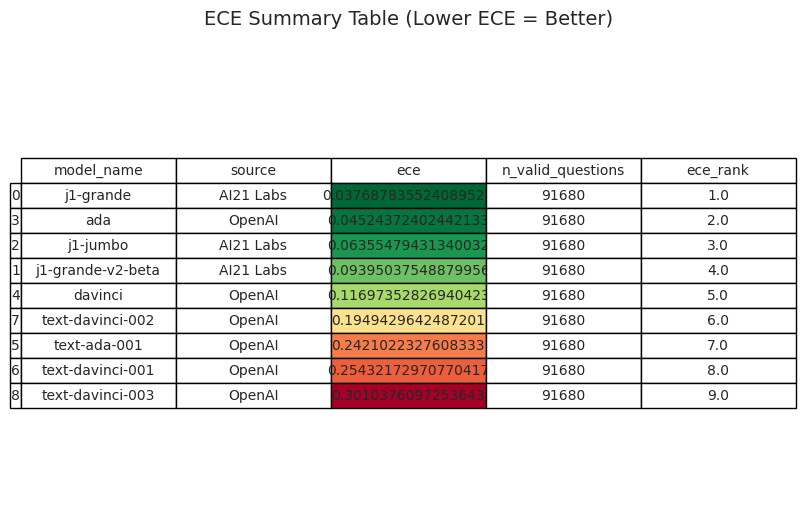

In [10]:
# Create summary table - Fixed version without dataframe_image
styles = ph.VIS_STYLES

summary_df = ece_results[['model_name', 'source', 'ece', 'n_valid_questions']].copy()
summary_df['ece_rank'] = summary_df['ece'].rank()
summary_df = summary_df.sort_values('ece_rank')

table_vis = summary_df.style.background_gradient(subset=['ece'], cmap='RdYlGn_r')\
                        .set_table_styles(styles)\
                        .set_properties(**{"font-size": "0.8rem"})\
                        .format({'ece': '{:.4f}', 'ece_rank': '{:.0f}'})

print("ECE Summary Table (Lower ECE = Better):")
display(table_vis)

# Alternative method to save table as image using matplotlib
def save_table_as_image(df, filename, figsize=(10, 6)):
    """Save DataFrame as image using matplotlib"""
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')
    
    # Create table
    table = ax.table(cellText=df.values,
                     rowLabels=df.index,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center')
    
    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # Add color gradient for ECE column
    ece_values = df['ece'].values
    norm = plt.Normalize(ece_values.min(), ece_values.max())
    colors = plt.cm.RdYlGn_r(norm(ece_values))
    
    # Find ECE column index
    ece_col_idx = df.columns.get_loc('ece')
    
    # Apply colors to ECE column
    for i in range(len(df)):
        table[(i+1, ece_col_idx)].set_facecolor(colors[i])
    
    plt.title('ECE Summary Table (Lower ECE = Better)', fontsize=14, pad=20)
    
    if SAVEFIG:
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

# Save table using matplotlib
if SAVEFIG:
    save_table_as_image(summary_df, './figures/ece_summary_table.png')

## Summary

This analysis provides comprehensive ECE evaluation of the language models, showing:

1. **Overall Calibration Performance**: Which models are best calibrated to human opinion distributions
2. **Reliability Diagrams**: Visual representation of calibration quality
3. **Comparative Analysis**: Performance comparison between AI21 Labs and OpenAI models

Lower ECE values indicate better calibration between model predictions and actual human response distributions.